# Análise de Letras Musicais Brasileiras

Notebook com uma análise do dataset de letras musicais brasileiras, com foco em **otimização de desempenho**, **melhoria da qualidade da análise** e **integração de modelos avançados de Processamento de Linguagem Natural (PLN)** do Hugging Face.

## 1. Configuração e Importação de Bibliotecas

Nesta seção, configuramos o ambiente e importamos todas as bibliotecas necessárias para a execução do projeto.

In [6]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
import torch

tqdm.pandas()
nltk.download('stopwords', quiet=True)
STOPWORDS_PT = set(stopwords.words('portuguese'))

# stopwords em inglês e espanhol, além de outras palavras comuns sem significado
STOPWORDS_EXTRAS = {
    'pra', 'pro', 'vou', 'vai', 'tá', 'né', 'yeah', 'ah', 'uh', 'hey',
    'you', 'my', 'to', 'the', 'a', 'in', 'it', 'is', 'i', 'of', 'and',
    'on', 'for', 'me', 'this', 'that', 'with', 'your', 'at', 'from',
    'be', 'are', 'was', 'were', 'do', 'does', 'did', 'can', 'could',
    'not', 'no', 'but', 'or', 'as', 'if', 'so', 'then', 'just'
}
STOPWORDS_PT.update(STOPWORDS_EXTRAS)

STOPWORDS_SONG = {'la', 'yeah', 'uh', 'oh', 'hey', 'baby', 'love', 'vida', 'coração', 'girl', 'man', 'deu', 'tão', 'fiz'}
STOPWORDS_PT.update(STOPWORDS_SONG)

MUSIC_STOPWORDS = set([
    "amor", "vida", "coração", "querer", "sentir", "vem",
    "assim", "quero", "nunca", "nada", "tudo", "sempre",
    "hoje", "saber", "mim", "você", "ele", "ela", "gente",
    "tá", "ai", "lá", "aqui", "olhar", "falar", "dizer",
    "depois", "antes", "homem", "mulher", "coisa"
])
STOPWORDS_PT.update(MUSIC_STOPWORDS)

STOPWORDS_PT.update([
    'a', 'agora', 'ainda', 'alguém', 'algum', 'alguma', 'algumas', 'alguns', 'aí',
    'amiga', 'amigo', 'amor', 'ano', 'anos', 'antes', 'ao', 'aos', 'apenas', 'apoio',
    'aqui', 'aquilo', 'as', 'assim', 'até', 'atrás', 'bem', 'bom', 'cada', 'caminho',
    'casa', 'cedo', 'coisa', 'com', 'como', 'coração', 'da', 'daí', 'dar', 'de',
    'deixa', 'deixar', 'dela', 'delas', 'dele', 'deles', 'demais', 'depois', 'desde',
    'dessa', 'desse', 'desta', 'deste', 'deu', 'dia', 'dias', 'diz', 'dizer', 'do',
    'dois', 'dos', 'e', 'é', 'ela', 'elas', 'ele', 'eles', 'em', 'enquanto',
    'então', 'entre', 'era', 'essa', 'essas', 'esse', 'esses', 'esta', 'estamos',
    'estas', 'este', 'estes', 'estou', 'eu', 'fala', 'falar', 'favor', 'faz', 'fazer',
    'feita', 'feito', 'fez', 'fica', 'ficar', 'fim', 'foi', 'for', 'forma', 'fosse',
    'gente', 'gosto', 'grande', 'hoje', 'homem', 'hora', 'horas', 'já', 'la', 'lá',
    'lado', 'lhe', 'longe', 'lugar', 'mão', 'mas', 'me', 'medo', 'melhor', 'mesma',
    'mesmo', 'meu', 'meus', 'mim', 'minha', 'minhas', 'momento', 'muita', 'muitas',
    'muito', 'muitos', 'mundo', 'na', 'nada', 'não', 'nas', 'nem', 'nenhum', 'nessa',
    'nesse', 'nesta', 'neste', 'ninguém', 'no', 'noite', 'nos', 'nós', 'nossa', 'nossas',
    'nosso', 'nossos', 'nova', 'novo', 'num', 'numa', 'nunca', 'o', 'os', 'ou',
    'outra', 'outras', 'outro', 'outros', 'para', 'paz', 'pela', 'pelas', 'pelo',
    'pelos', 'perto', 'pode', 'poder', 'pois', 'por', 'porque', 'porquê', 'pouco',
    'pra', 'preciso', 'primeiro', 'próprio', 'puder', 'qual', 'quando', 'quanto',
    'que', 'quê', 'quem', 'quer', 'querer', 'quero', 'se', 'só', 'sei', 'sem',
    'sempre', 'ser', 'será', 'seu', 'seus', 'sim', 'sobre', 'solidão', 'somente',
    'sonho', 'sou', 'sua', 'suas', 'tá', 'talvez', 'também', 'tanta', 'tantas',
    'tanto', 'tão', 'te', 'tem', 'tempo', 'ter', 'teu', 'teus', 'tipo', 'toda',
    'todas', 'todo', 'todos', 'trás', 'tu', 'tua', 'tuas', 'tudo', 'um', 'uma',
    'vai', 'vamos', 'vão', 'vem', 'ver', 'vez', 'vida', 'você', 'vocês', 'volta', 'onde'
])

# (GPU ou CUDA se disponível)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo configurado para uso: {DEVICE}")

Dispositivo configurado para uso: cpu


## 2. Carregamento e Amostragem Otimizada dos Dados

O arquivo `brazilian_lyrics.csv` é grande. Para otimizar o carregamento e permitir a análise de um volume maior de dados sem comprometer a memória, utilizamos a função `read_csv` do pandas com a opção `chunksize`. Isso nos permite processar o arquivo em blocos, carregando uma amostra maior.

In [7]:
FILE_PATH = "data/brazilian_lyrics.csv"
SAMPLE_SIZE = 50000  # Aumentado para 50.000 músicas
CHUNK_SIZE = 100000 # Tamanho do bloco para leitura

df_sample = pd.DataFrame()
total_read = 0

print(f"Iniciando leitura e amostragem de até {SAMPLE_SIZE} músicas...")

for chunk in tqdm(pd.read_csv(FILE_PATH, chunksize=CHUNK_SIZE), desc="Lendo chunks"): 
    # Filtra colunas e remove nulos na coluna 'text'
    chunk = chunk[['text', 'genre']].dropna(subset=['text'])
    
    # Adiciona ao DataFrame de amostra até atingir o limite
    remaining = SAMPLE_SIZE - total_read
    if remaining > 0:
        df_sample = pd.concat([df_sample, chunk.head(remaining)])
        total_read = len(df_sample)
    
    if total_read >= SAMPLE_SIZE:
        break

print(f"Total de músicas carregadas: {len(df_sample)}")
print(f"Exemplo de letra (raw): {df_sample['text'].iloc[0][:100]}...")

Iniciando leitura e amostragem de até 50000 músicas...


Lendo chunks: 0it [00:02, ?it/s]

Total de músicas carregadas: 50000
Exemplo de letra (raw): Carolina é uma menina bem difícil de esquecer Andar bonito e um brilho no olhar Tem um jeito adolesc...


## 3. Pré-processamento Otimizado das Letras

O pré-processamento é a etapa mais custosa. Para otimizar, A limpeza inclui:

1. **Remoção de pontuações e caracteres especiais.**
2. **Conversão para minúsculas.**
3. **Remoção de *stopwords* (palavras comuns como 'o', 'a', 'de').**
4. **Remoção de espaços em branco extras.**

A coluna `clean_text` será usada para a análise de tópicos e nuvens de palavras.

In [8]:
def clean_text(text):
    if pd.isna(text):
        return ""

    text = str(text).lower()

    # Remove links
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    # Remove emojis e símbolos musicais
    text = re.sub(r'[^\w\s]', '', text)

    # Normaliza letras repetidas (amooooor -> amor)
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Remove pontuação mantendo acentos
    text = re.sub(r'[^a-zA-ZÀ-ÖØ-öø-ÿ\s]', '', text)

    # Normaliza espaços
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove stopwords
    words = [word for word in text.split() if word not in STOPWORDS_PT and len(word) > 2]
    return " ".join(words)

print("Iniciando limpeza de textos...")
df_sample['clean_text'] = df_sample['text'].progress_apply(clean_text)

# Remove músicas que ficaram vazias após a limpeza
df_sample = df_sample[df_sample['clean_text'].str.strip() != ""]
print(f"Amostra após limpeza: {len(df_sample)} músicas")
print(f"Exemplo de letra (raw): {df_sample['text'].iloc[0][:300]}...")

Iniciando limpeza de textos...


100%|██████████| 50000/50000 [00:17<00:00, 2874.24it/s]

Amostra após limpeza: 49993 músicas
Exemplo de letra (raw): Carolina é uma menina bem difícil de esquecer Andar bonito e um brilho no olhar Tem um jeito adolescente que me faz enlouquecer E um molejo que eu não vou te enganar Maravilha feminina, meu docinho de pavê Inteligente, ela é muito sensual Te confesso que estou apaixonado por você Ô, Carolina, isso é...


## 4. Análise de Tópicos (LDA) por Gênero

A Análise de Alocação Latente de Dirichlet (LDA) é utilizada para descobrir os **tópicos subjacentes** em cada gênero musical. Para garantir a robustez da análise, filtramos os gêneros com menos de 50 músicas na amostra, evitando ruído em grupos muito pequenos. O processo é iterativo e o modelo LDA é treinado separadamente para cada gênero, permitindo uma análise temática mais específica.

In [9]:
MIN_SONGS_PER_GENRE = 50
N_TOPICS = 5
N_TOP_WORDS = 10

# Filtra gêneros com número mínimo de músicas
genre_counts = df_sample['genre'].value_counts()
valid_genres = genre_counts[genre_counts >= MIN_SONGS_PER_GENRE].index
df_sample_topics = df_sample[df_sample['genre'].isin(valid_genres)].copy()

print(f"Gêneros válidos (>= {MIN_SONGS_PER_GENRE} músicas): {len(valid_genres)}")
print(f"Amostra após filtrar gêneros pequenos: {len(df_sample_topics)} músicas")

lda_results = []

print("Extraindo tópicos por gênero...")
for genre in tqdm(valid_genres, desc="Processando Gêneros"):
    sub_df = df_sample_topics[df_sample_topics['genre'] == genre]
    texts = sub_df['clean_text'].tolist()
    
    if len(texts) < N_TOPICS: continue
    
    # Criação da matriz TF-IDF
    vectorizer = TfidfVectorizer(
        max_df=0.80,
        min_df=3,
        max_features=5000,
        ngram_range=(1,2),
        stop_words=list(STOPWORDS_PT))
    try:
        dtm = vectorizer.fit_transform(texts)
    except ValueError: # Evita erro se o vocabulário for muito pequeno
        continue
    
    # Aplicação do LDA
    lda = LatentDirichletAllocation(
        n_components=N_TOPICS,
        random_state=42,
        max_iter=20,
        learning_method='batch',
        learning_decay=0.7,
        evaluate_every=1
    )
    lda.fit(dtm)
    
    # Extração das top palavras por tópico
    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words.append(" ".join([feature_names[i] for i in topic.argsort()[:-N_TOP_WORDS - 1:-1]]))
    
    # Atribuição do tópico principal a cada música
    topic_probs = lda.transform(dtm)
    main_topic = np.argmax(topic_probs, axis=1)
    
    # Armazena resultados
    sub_df = sub_df.copy()
    sub_df['main_topic'] = main_topic
    sub_df['topic_words'] = sub_df['main_topic'].apply(lambda x: top_words[x])
    lda_results.append(sub_df)
    
df_sample_topics = pd.concat(lda_results)
print(f"Total de músicas com tópicos: {len(df_sample_topics)}")

Gêneros válidos (>= 50 músicas): 18
Amostra após filtrar gêneros pequenos: 49872 músicas
Extraindo tópicos por gênero...


Processando Gêneros: 100%|██████████| 18/18 [30:17<00:00, 100.96s/it]  

Total de músicas com tópicos: 49872


## 5. Análise de Sentimento com Hugging Face

Para uma análise de sentimento mais precisa e moderna, substituímos a implementação anterior por um modelo pré-treinado do Hugging Face, o **`tabularisai/multilingual-sentiment-analysis`**.

**Otimização:** Para lidar com textos longos (letras inteiras), o modelo é executado em lotes (batches) e com o uso do `DEVICE` (GPU, se disponível), o que acelera drasticamente o processamento em comparação com a iteração linha a linha do código original.

In [12]:
# Modelo com max_length 512, mais adequado para letras de música
MODEL_NAME = "tabularisai/multilingual-sentiment-analysis"
BATCH_SIZE = 32
df_sample_sentiments = df_sample_topics.sample(1000, random_state=42).copy()

try:
    # Carrega o pipeline de sentimento do Hugging Face com o novo modelo
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model=MODEL_NAME,
        tokenizer=MODEL_NAME,
        device=0 if DEVICE.type == 'cuda' else -1, # 0 para GPU, -1 para CPU
        framework="pt"
    )
    print(f"Pipeline de sentimento do Hugging Face carregado: {MODEL_NAME}")
    
    # Função para processar em batches
    def get_sentiment_batch(texts):
        results = sentiment_pipeline(texts, batch_size=BATCH_SIZE, truncation=True)
        return [r['label'] for r in results]
    
    # Divide o DataFrame em batches e aplica a função
    texts_to_analyze = df_sample_sentiments['text'].sample(1000, random_state=42).tolist()
    all_sentiments = []
    
    for i in tqdm(range(0, len(texts_to_analyze), BATCH_SIZE), desc="Analisando Sentimento (HF)"):
        batch = texts_to_analyze[i:i + BATCH_SIZE]
        all_sentiments.extend(get_sentiment_batch(batch))
        
    df_sample_sentiments['sentiment'] = all_sentiments
    
    print("\nDistribuição de Sentimentos:")
    print(df_sample_sentiments['sentiment'].value_counts(dropna=False))
    
except Exception as e:
    print(f"Erro ao carregar ou executar o modelo do Hugging Face: {e}")
    print("Análise de sentimento será pulada.")
    df_sample_sentiments['sentiment'] = 'N/A'

Device set to use cpu


Pipeline de sentimento do Hugging Face carregado: tabularisai/multilingual-sentiment-analysis


Analisando Sentimento (HF): 100%|██████████| 32/32 [06:13<00:00, 11.67s/it]


Distribuição de Sentimentos:
sentiment
Very Negative    502
Very Positive    405
Neutral           46
Positive          25
Negative          22
Name: count, dtype: int64


## 6. Visualizações e Resultados

Nesta etapa, geramos as visualizações para interpretar os resultados da análise de tópicos e sentimentos. As nuvens de palavras e os gráficos de distribuição de sentimentos fornecem um resumo visual dos padrões encontrados nas letras.

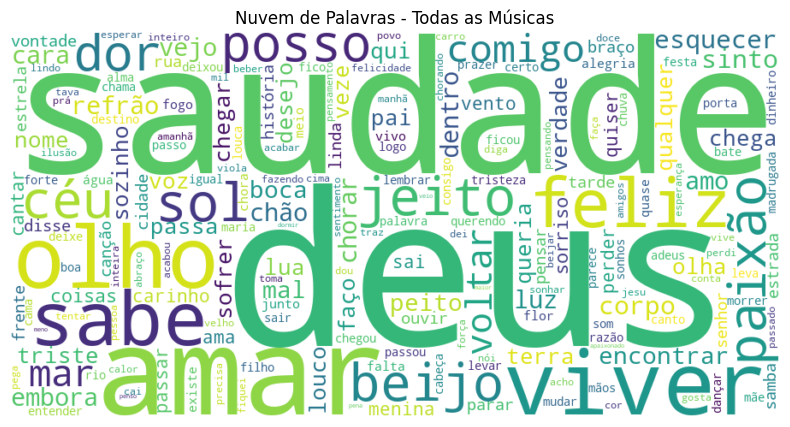


--- sertanejo (20172 músicas) ---


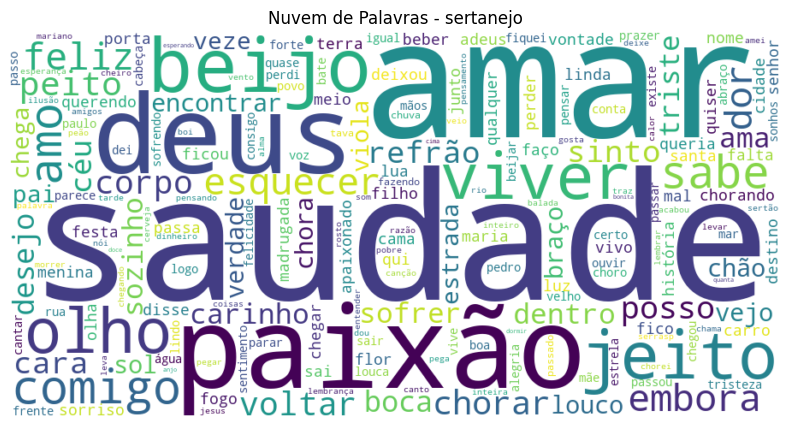

Tópicos Principais (LDA):
  Tópico 1: beber festa cara balada dançar cerveja mulherada pegar nóis pega

--- mpb (10292 músicas) ---


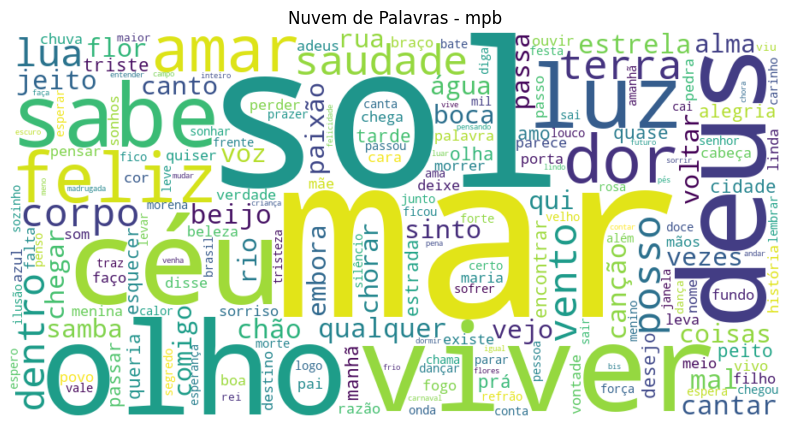

Tópicos Principais (LDA):
  Tópico 1: feliz rio lua bate papai sol flor sabiá canta idade

--- rock (6393 músicas) ---


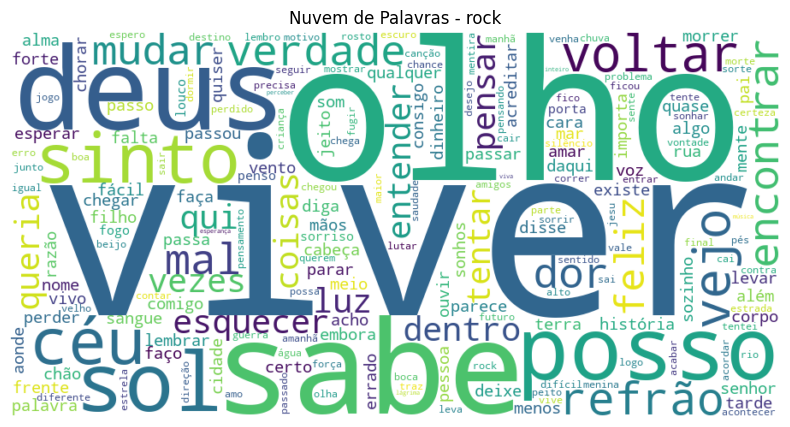

Tópicos Principais (LDA):
  Tópico 1: viver posso olhos sinto voltar encontrar mudar sabe esquecer entender

--- Bossa Nova (4108 músicas) ---


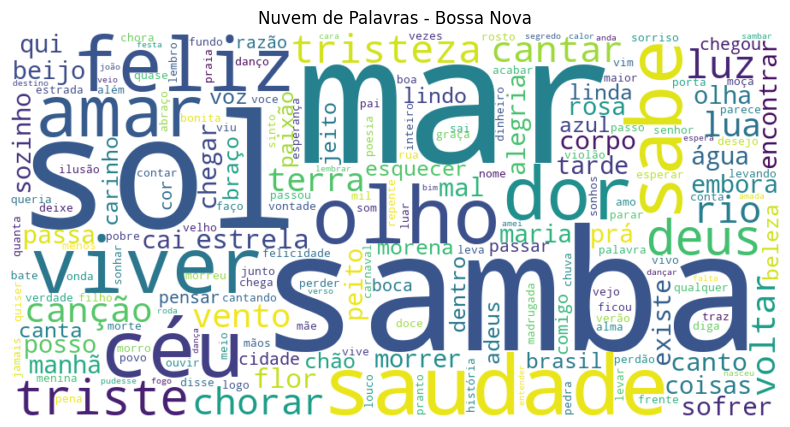

Tópicos Principais (LDA):
  Tópico 1: samba barquinho mar danço baiana brasil samba samba raiar saudade danço samba

--- pop (3769 músicas) ---


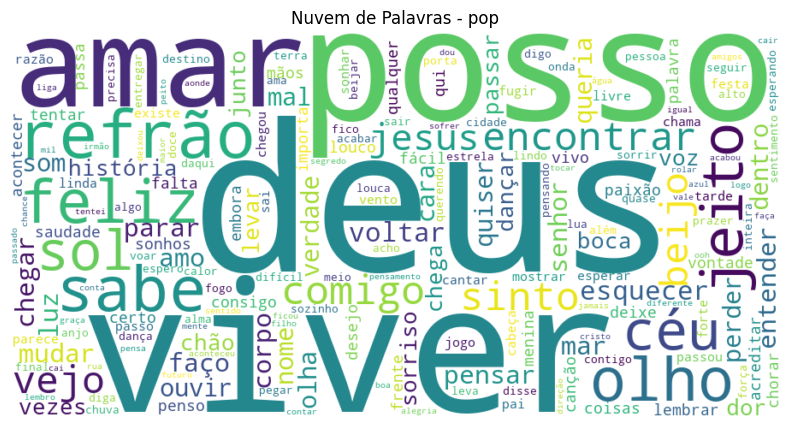

Tópicos Principais (LDA):
  Tópico 1: deus viver amar posso refrão feliz sabe encontrar sol sinto

--- axe (1219 músicas) ---


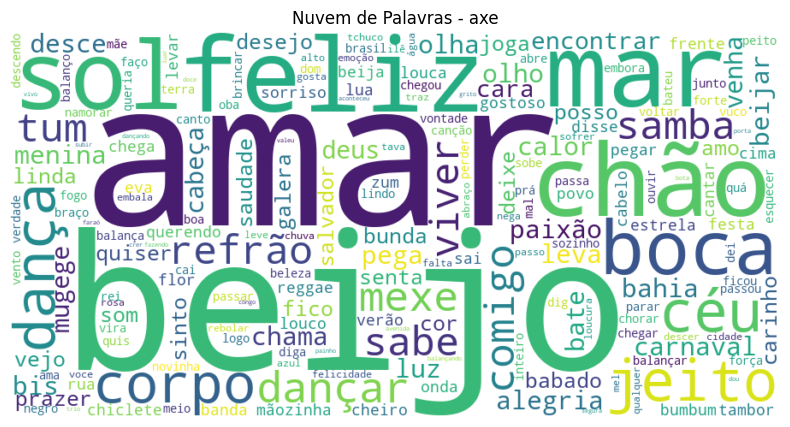

Tópicos Principais (LDA):
  Tópico 1: senta bunda amar desce dançar feliz jeito chão posso faraó

Projeto concluído! Resultados salvos em data/lyrics_with_topics_and_sentiment.csv com as colunas: genre, clean_text


In [13]:
def plot_wordcloud(texts, title="Nuvem de palavras"):
    text = " ".join(texts)
    if len(text.strip())==0:
        print(f"Nuvem vazia para {title}")
        return
    wc = WordCloud(width=900, height=450, background_color="white", collocations=False).generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(title)
    plt.show()
    plt.close()

if not df_sample_topics.empty:
    # 6.1. Nuvem de Palavras Geral
    plot_wordcloud(df_sample_topics['clean_text'], title="Nuvem de Palavras - Todas as Músicas")
    
    # 6.2. Distribuição de Sentimentos
    if 'sentiment' in df_sample_topics.columns and df_sample_topics['sentiment'].isin(['POSITIVE', 'NEGATIVE', 'NEUTRAL']).any():
        plt.figure(figsize=(8,5))
        sns.countplot(x='sentiment', data=df_sample_topics, order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
        plt.title('Distribuição de Sentimentos (Hugging Face)')
        plt.xlabel('Sentimento')
        plt.ylabel('Contagem de Músicas')
        plt.show()
        plt.close()
        
    # 6.3. Nuvem de Palavras e Tópicos por Gênero (Top 6)
    for genre in df_sample_topics['genre'].unique()[:6]:
        sub = df_sample_topics[df_sample_topics['genre'] == genre]
        print(f"\n--- {genre} ({len(sub)} músicas) ---")
        plot_wordcloud(sub['clean_text'], title=f"Nuvem de Palavras - {genre}")
        
        # Exibe os tópicos encontrados pelo LDA
        if 'topic_words' in sub.columns:
            print("Tópicos Principais (LDA):")
            # Pega o primeiro valor, pois todos os daquele gênero são iguais após o processamento
            topic_words_str = sub['topic_words'].iloc[0]
            for i, words in enumerate(topic_words_str.split(', ')): 
                print(f"  Tópico {i+1}: {words}")
        
    # 6.4. Sentimento por Gênero (Top 6)
    if 'sentiment' in df_sample_topics.columns and df_sample_topics['sentiment'].isin(['POSITIVE', 'NEGATIVE', 'NEUTRAL']).any():
        top_genres = df_sample_topics['genre'].value_counts().nlargest(6).index
        df_top_genres = df_sample_topics[df_sample_topics['genre'].isin(top_genres)]
        
        plt.figure(figsize=(12, 6))
        sns.countplot(x='genre', hue='sentiment', data=df_top_genres, order=top_genres, hue_order=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])
        plt.title('Distribuição de Sentimentos por Gênero (Top 6)')
        plt.xlabel('Gênero Musical')
        plt.ylabel('Contagem de Músicas')
        plt.xticks(rotation=45, ha='right')
        plt.legend(title='Sentimento')
        plt.tight_layout()
        plt.show()
        plt.close()

    # 6.5. Salvamento dos Resultados
    OUTPATH = "data/lyrics_with_topics_and_sentiment.csv"
    COLUMNS_TO_SAVE = ['genre', 'clean_text']
    existing_columns = [col for col in COLUMNS_TO_SAVE if col in df_sample_topics.columns]
    
    if existing_columns:
        df_sample_topics[existing_columns].to_csv(OUTPATH, index=False)
        print(f"\nProjeto concluído! Resultados salvos em {OUTPATH} com as colunas: {', '.join(existing_columns)}")
    else:
        print("\nErro: Nenhuma das colunas especificadas para salvamento foi encontrada no DataFrame.")


## 7. Conclusão

A ser feita.